<a href="https://colab.research.google.com/github/OdysseusPolymetis/philo_num_grenoble_24/blob/main/1_why_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Natural Language Processing : tokenizing, lemmatizing, postagging and named entities**



You're free to use any lib that suits you better for your research. Here we're going to use `stanza` and `spacy`. Generally speaking, I would encourage the use of `stanza`, as in my field it generally got me the best results.

In [1]:
!git clone https://github.com/PerseusDL/treebank_data.git

Cloning into 'treebank_data'...
remote: Enumerating objects: 2635, done.
remote: Counting objects: 100% (224/224), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 2635 (delta 144), reused 216 (delta 142), pack-reused 2411
Receiving objects: 100% (2635/2635), 75.59 MiB | 19.16 MiB/s, done.
Resolving deltas: 100% (1499/1499), done.
Updating files: 100% (275/275), done.


In [2]:
import os
import xml.etree.ElementTree as ET
import string
import gdown

In [4]:
file_id = "1MZ4ld8j30ye3YGYy-T7V3Cyy1c4dlGks"
output_file = "stopwords_gk.txt"
#gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file)
stopwords = open("/content/stopwords_gk.txt",'r',encoding="utf8").read().split("\n")

In [5]:
greek_dir = '/content/treebank_data/v2.1/Greek/texts'
latin_dir = '/content/treebank_data/v2.1/Latin/texts'

In [6]:
def parse_treebank_file(file_path):

    tree = ET.parse(file_path)
    root = tree.getroot()

    indexed_gold_sentences = []
    file_id1 = os.path.basename(file_path)
    print(file_id1)
    print(len(root.findall('.//sentence')))

    for i, sentence in enumerate(root.findall('.//sentence')):
        words = []
        for word in sentence.findall('.//word'):
            words.append({
                'form': word.get('form'),
                'lemma': word.get('lemma'),
                'postag': word.get('postag'),
                'relation': word.get('relation'),
                'head': word.get('head')
            })
        indexed_gold_sentences.append( words)
    return indexed_gold_sentences

In [7]:
def process_gold_directory(directory, filter_text):
    all_sentences = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            if filter_text in file:
                file_path = os.path.join(root, file)
                sentences = parse_treebank_file(file_path)

                for sentence in sentences:
                    all_sentences.append(sentence)

                print(f"Processed {file_path}")

    return all_sentences

In [8]:
treebank_sentences=process_gold_directory(greek_dir, 'tlg0012')

tlg0012.tlg002.perseus-grc1.tb.xml
6723
Processed /content/treebank_data/v2.1/Greek/texts/tlg0012.tlg002.perseus-grc1.tb.xml
tlg0012.tlg001.perseus-grc1.tb.xml
8415
Processed /content/treebank_data/v2.1/Greek/texts/tlg0012.tlg001.perseus-grc1.tb.xml


In [9]:
forms=[]
lemmas=[]
no_stop=[]

for sentence in treebank_sentences:
  for word in sentence:
    if word["form"] not in string.punctuation and word["lemma"] not in stopwords:
      if word["lemma"] is not None:
        lemmas.append(word["lemma"])
        no_stop.append(word["lemma"])
      forms.append(word["form"])
    elif word["form"] not in string.punctuation:
      if word["lemma"] is not None:
        lemmas.append(word["lemma"])
      forms.append(word["form"])

In [10]:
len(lemmas)

208205

In [11]:
len(forms)

211957

In [12]:
len(no_stop)

104548

##What's NLP and why do we need it ?
Generally speaking, loads of people use NLP as a preprocessing phase, for further textual treatment. And it is absolutely necessary if you want to avoid noise in statistical analysis and machine learning uses.
<br>Here, I'm going to show you what you get when you don't preprocess and when you do, with a basic example.

Let's say we want to create a word cloud, showing which terms are more important in a specific text.
<br>Here's a cloud produced right after just splitting the _Trois Mousquetaires_ and projecting the text in a word cloud, with no preprocessing.

In [13]:
import unicodedata
def remove_accents_from_list(words_list):
    """
    Remove accents and other diacritical marks from a list of unicode strings.
    This is particularly useful for Greek polytonic characters.
    """
    def remove_accents(input_str):
        nfkd_form = unicodedata.normalize('NFKD', input_str)
        return "".join([c for c in nfkd_form if not unicodedata.combining(c)])

    return [remove_accents(word) for word in words_list]

In [111]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

def create_word_cloud(words_list, title):
    text = ' '.join(words_list)

    # Créer un masque avec un canal alpha pour la transparence
    radius = 495
    diameter = radius * 2
    center = radius
    x, y = np.ogrid[:diameter, :diameter]
    mask = (x - center) ** 2 + (y - center) ** 2 > radius ** 2
    mask = 255 * mask.astype(int)

    # Créer une image RGBA avec le masque pour la transparence
    mask_rgba = np.dstack((mask, mask, mask, 255 - mask))

    # Créer le nuage de mots avec le masque
    wordcloud = WordCloud(repeat=False, width=diameter, height=diameter,
                          background_color=None, mode="RGBA", colormap='plasma',
                          mask=mask_rgba).generate(text)

    # Afficher le nuage de mots
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

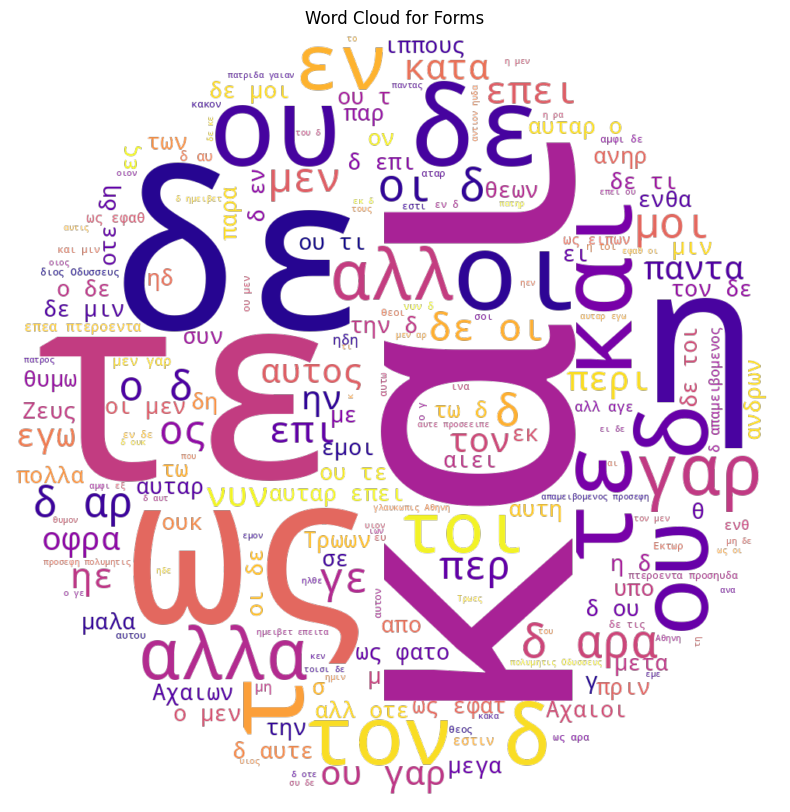

In [112]:
create_word_cloud(remove_accents_from_list(forms), 'Word Cloud for Forms')

This cloud is useless. Why ? because we don't need to see that the word "était" is important, we basically already know that without a word cloud. And what is more, we have several occurrences of the same basic word, "était", "fut", "est", etc.
<br>So let's **lemmatize**. Here's the word cloud we get.

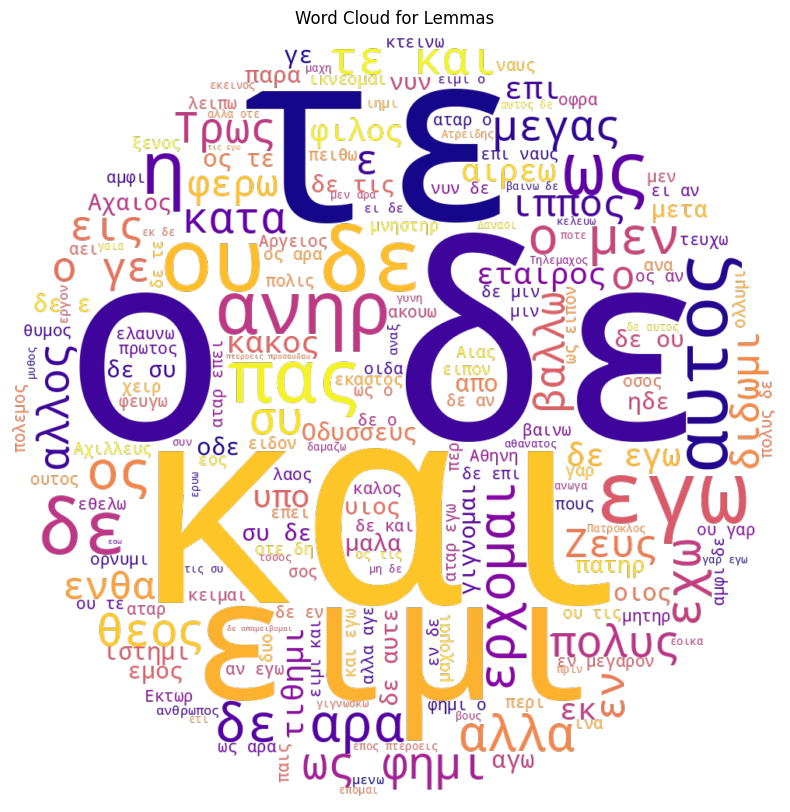

In [107]:
create_word_cloud(remove_accents_from_list(lemmas), 'Word Cloud for Lemmas')

A bit better, but not so good either. A lot of words are of no use as we already know they are very frequent and have no semantic weight.
<br>So, this time, we're going to remove **stopwords**, and punctuation.

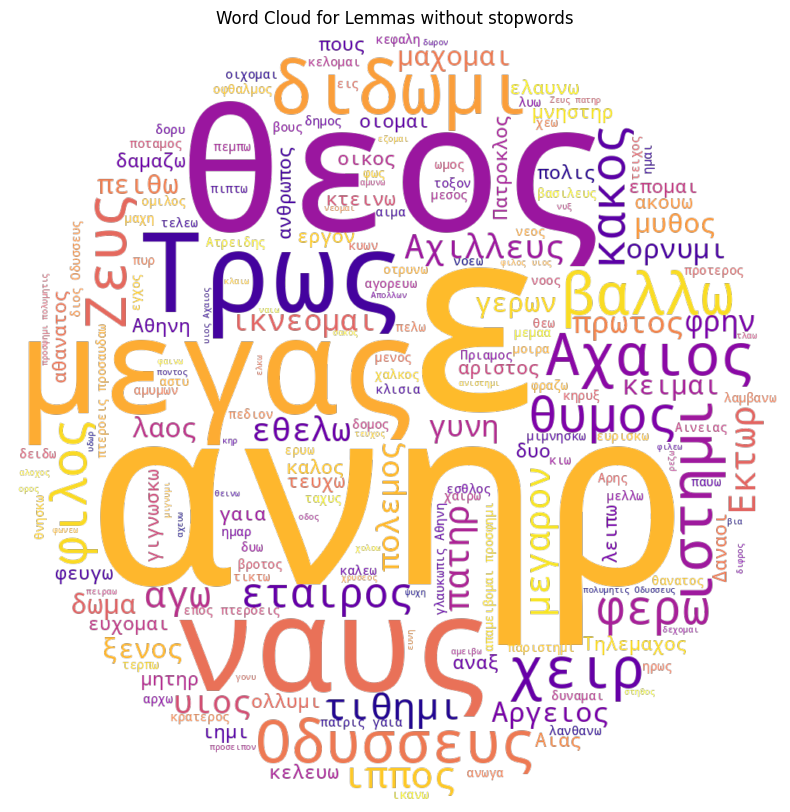

In [108]:
create_word_cloud(remove_accents_from_list(no_stop), 'Word Cloud for Lemmas without stopwords')

Now we get a more satisfying word cloud, that should give more information about the text we're working on.

## Expérience similaire sur les postags

In [33]:
postags=[]
no_stop_postags=[]

for sentence in treebank_sentences:
  for word in sentence:
    if word["form"] not in string.punctuation and word["lemma"] not in stopwords:
      if word["postag"] is not None:
        postags.append(word["postag"][0])
        no_stop_postags.append(word["postag"][0])
    elif word["form"] not in string.punctuation:
      if word["postag"] is not None:
        postags.append(word["postag"][0])

In [113]:
def create_word_cloud_postags(words_list, title):
    text = ' '.join(words_list)
    diameter = 1000
    radius = diameter // 2
    center = radius
    x, y = np.ogrid[:diameter, :diameter]
    mask = (x - center) ** 2 + (y - center) ** 2 > radius ** 2
    mask = 255 * mask.astype(int)
    mask_rgba = np.dstack((mask, mask, mask, 255 - mask))
    wordcloud = WordCloud(
        width=diameter,
        height=diameter,
        background_color=None,  # pour un fond transparent
        mode="RGBA",
        colormap='plasma',
        mask=mask_rgba,
        collocations=False,
        repeat=False,
        scale=2,
        min_font_size=10,
        max_words=200
    ).generate(text)

    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [114]:
print(postags[0:10])

['n', 'p', 'v', 'n', 'a', 'p', 'd', 'd', 'v', 'c']


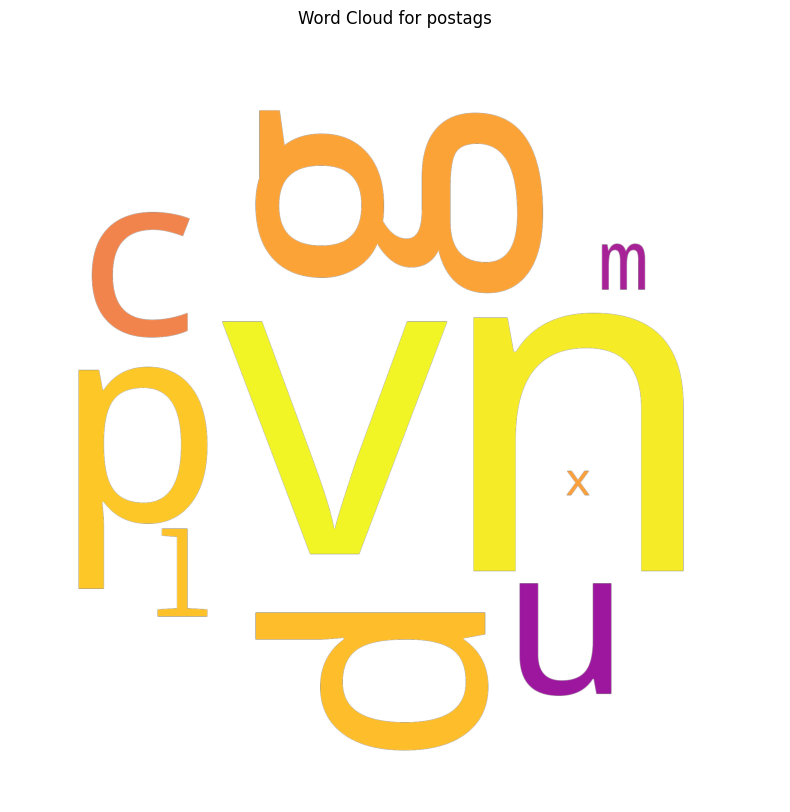

In [115]:
create_word_cloud_postags(postags, 'Word Cloud for postags')

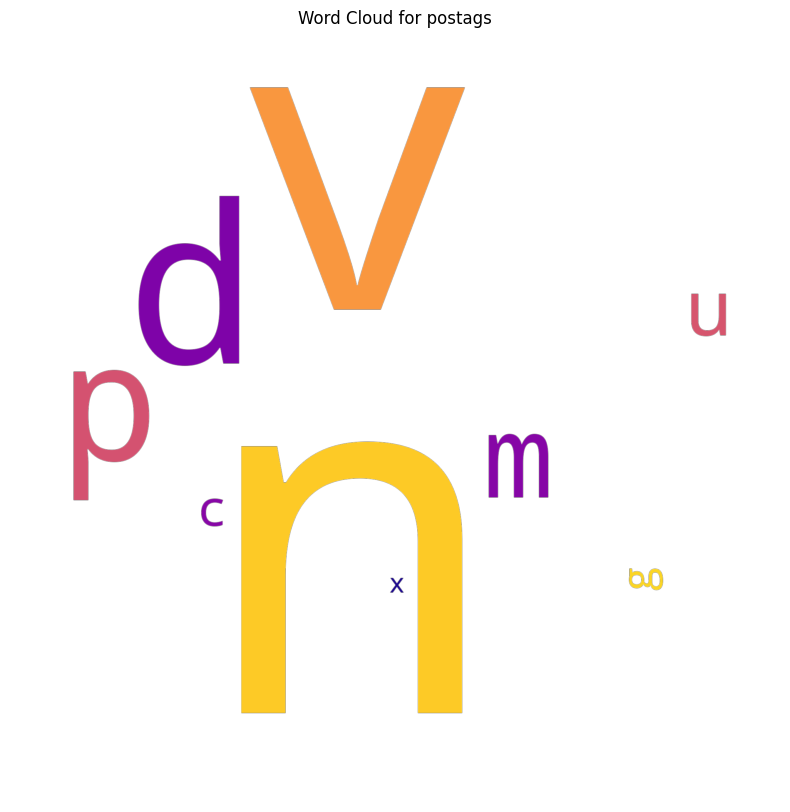

In [116]:
create_word_cloud_postags(no_stop_postags, 'Word Cloud for postags')

##How do you do it ?

##**Some online useful tools**

###**UDPipe**
You'll find it [here](https://lindat.mff.cuni.cz/services/udpipe/).
<br>This tool is pretty useful if you want to get access to a preprocessed text quickly with no programming skills.

###**Deucalion**
You'll find it [here](https://dh.chartes.psl.eu/deucalion/api/fr/).
<br>This tool is useful for Latin, Greek and certain French types.

###**VoyantTools**
You'll find it [here](https://voyant-tools.org/).
<br>This is no NLP preprocessing tool, but once you've done a bit of preprocessing on your text, it is a useful tool to visualize your results.

#**TOKENIZING, LEMMATIZING, POSTAGGING**

Now let's try **`stanza`**.
<br> we'll use it on a small string variable, taken from the _Misérables_.

You can also try the following code on the whole book, which is available with the `gdown` below.
<br>Execute the three following cells only if you want to try nlp on the full text.

In [45]:
!pip install stanza

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 933.2/933.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.5/397.5 kB 33.0 MB/s eta 0:00:00


In [43]:
filepath_of_text = "/content/catilinaires.txt"

In [44]:
full_text = open(filepath_of_text, encoding="utf-8").read()

##**stanza**

I generally use `stanza` for three reasons :
<br>- there is a very large number of languages it can be applied to (which you can check [here](https://stanfordnlp.github.io/stanza/performance.html)),
<br>- it's pretty quick, and performs well on large corpora,
<br>- it's easy to manipulate.

Later on, we'll also try different kinds of models, based on BERT models and other contextual models, but that needs to be a bit more advanced in programming.

To download a specific language model in `stanza`, you'll need the code letters corresponding to each models, which you can get [here](https://stanfordnlp.github.io/stanza/performance.html).
<br>Let's begin with a French model.

In [46]:
import stanza
stanza.download('la')

INFO:stanza:Downloading default packages for language: la (Latin) ...


INFO:stanza:Finished downloading models and saved to /root/stanza_resources.


Loads of models have several pipelines which you may not want to execute all the time as it can slow down the process (eg, here we won't, for the time being, be using the NER process, so we don't need to call it). You can specify the processes needed this way :

In [47]:
nlp_stanza = stanza.Pipeline(lang='la', processors='tokenize,pos,lemma')

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: la (Latin):
| Processor | Package       |
-----------------------------
| tokenize  | ittb          |
| pos       | ittb_nocharlm |
| lemma     | ittb_nocharlm |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


Now we can analyze the `preface` variable. It will give us a list of sentences with values attached to one specific token.

In [48]:
catilinaires_stanza=nlp_stanza(full_text)

Let's go through each sentence and check the results on each word.

In [49]:
for sent in catilinaires_stanza.sentences:
  for token in sent.words:
    print(token.text + ' - ' + token.lemma + ' - ' + token.pos)

Quo - qui - PRON
usque - usque - ADP
tandem - tandem - ADV
abutere - abutor - VERB
, - , - PUNCT
Catilina - Catilina - NOUN
, - , - PUNCT
patientia - patientia - NOUN
nostra - noster - DET
? - ? - PUNCT
quam - qui - PRON
diu - diu - ADV
etiam - etiam - ADV
furor - furor - NOUN
iste - iste - DET
tuus - tuus - DET
nos - nos - PRON
eludet - eludeo - VERB
? - ? - PUNCT
quem - qui - PRON
ad - ad - ADP
finem - finis - NOUN
sese - se - PRON
effrenata - effreno - VERB
iactabit - iacto - VERB
audacia - audacia - NOUN
? - ? - PUNCT
Nihilne - Nihilne - VERB
te - tu - PRON
nocturnum - nocturnus - ADJ
praesidium - praesidium - NOUN
Palati - Palati - NOUN
, - , - PUNCT
nihil - nihil - PRON
urbis - urbs - NOUN
uigiliae - uigilia - NOUN
, - , - PUNCT
nihil - nihil - PRON
timor - timor - NOUN
populi - populus - NOUN
, - , - PUNCT
nihil - nihil - PRON
concursus - concursus - NOUN
bonorum - bonus - ADJ
omnium - omnis - DET
, - , - PUNCT
nihil - nihil - PRON
hic - hic - DET
munitissimus - munitus - ADJ
ha

Not so bad.

# **NER : NAMED ENTITY RECOGNITION**

**Named entities** are elements that can be culturally idenfiable. They are not necessarily one unique word. For example, "Rome" is a named entity, but a NER tool could also associate it with the expression "the city of seven hills".

Let's try with **`stanza`** and redefine the Pipeline, using the `ner` process.



In [53]:
!pip install spacy
!pip install https://huggingface.co/latincy/la_core_web_lg/resolve/main/la_core_web_lg-any-py3-none-any.whl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.6/234.6 MB 5.2 MB/s eta 0:00:00


Let's take a random slice of the _Misérables_.

In [118]:
import spacy
nlp = spacy.load("la_core_web_lg")

In [55]:
doc = nlp(full_text)

for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

Catilina 27 35 LOC
Senatus 600 607 PERSON
Viuit 656 661 PERSON
Catilina 892 900 PERSON
P. Scipio 1036 1045 PERSON
Ti. 1065 1068 PERSON
Gracchum 1069 1077 PERSON
Catilinam 1145 1154 LOC
C. Seruilius 1272 1284 PERSON
Ahala 1285 1290 PERSON
Sp 1291 1293 PERSON
Maelium 1295 1302 PERSON
Catilina 1518 1526 LOC
Decreuit 1654 1662 PERSON
L. Opimius 1683 1693 PERSON
C. Gracchus 1829 1840 PERSON
M. Fuluius 1900 1910 PERSON
C. Mario 1947 1955 PERSON
L. Valerio 1959 1969 PERSON
L. Saturninum 2028 2041 PERSON
C. Seruilium 2058 2070 PERSON
Catilina 2355 2363 LOC
Castra 2599 2605 LOC
Italia 2614 2620 LOC
Etruriae 2647 2655 LOC
Catilina 2883 2891 LOC
Tandem 3550 3556 PERSON
Quirites 3568 3576 PERSON
L. Catilinam 3578 3590 PERSON
Abiit 3791 3796 PERSON
Quirites 4635 4643 PERSON
Quirites 5086 5094 PERSON
L. Catilinam 5127 5139 PERSON
L. Catilinam 5561 5573 PERSON
Quirites 5903 5911 PERSON
Tongilium 6097 6106 PERSON
Publicium 6154 6163 PERSON
Minucium 6167 6175 PERSON
Piceno 6415 6421 LOC
Q. Metellus 643

If you want to check on the whole book, you'll need to have the previous variable `full_text` executed beforehand.

Now let's try some basic visualizations on preprocessed data.

First, let's perform it on the whole text. I'll reprint the three optional cells used before just below. This part should take some time as the text is pretty long.



And there comes the longest part :
<br>(Careful, this parts takes a lot of cuda, if you're out of cuda (CUDA out of memory), you need to reload the virtual environment in "Tools" and re-execute some of the variable instances)

As your cuda may be too low, we might need to use text batching to aleviate its use. You can modify the number of sentences taken into account by changing the variable `batch_size`.
<br>For this part, we only want lemmas, and the following function will allow us to get them all, without cuda memory problems.

This part takes roughly 5 minutes for the _Misérables_

In [61]:
import nltk

In [69]:
lemmas_catilinaires=[]
for sent in catilinaires_stanza.sentences:
  for token in sent.words:
    lemmas_catilinaires.append(token.lemma)
forms_catilinaires=[]
for sent in catilinaires_stanza.sentences:
  for token in sent.words:
    forms_catilinaires.append(token.text)

And let's check what's inside.

In [70]:
print(lemmas_catilinaires[0:20])
print(forms_catilinaires[0:20])

['qui', 'usque', 'tandem', 'abutor', ',', 'Catilina', ',', 'patientia', 'noster', '?', 'qui', 'diu', 'etiam', 'furor', 'iste', 'tuus', 'nos', 'eludeo', '?', 'qui']
['Quo', 'usque', 'tandem', 'abutere', ',', 'Catilina', ',', 'patientia', 'nostra', '?', 'quam', 'diu', 'etiam', 'furor', 'iste', 'tuus', 'nos', 'eludet', '?', 'quem']


And now let's use some basic `nltk` features, such as the concordance tables (and let's download the stopwords).

The nltk stopwords list being very small, I'll add some more words.

In [59]:
stopset = open("/content/stopwords_lat.txt", encoding="utf-8").read().split("\n")

In [60]:
for lemma in lemmas_catilinaires:
    if not isinstance(lemma, str):
        print(f"Type non string trouvé : {lemma} (type : {type(lemma)})")

In [72]:
nltk_lemmas = nltk.Text(lemmas_catilinaires)

In [73]:
nltk_lemmas.concordance("Catilina")

Displaying 18 of 18 matches:
qui usque tandem abutor , Catilina , patientia noster ? qui diu etiam
ror atque tela uito . Ad mors tu , Catilina , duco ius consulus iam pridem opo
ceo . Habemus seno consulo in tu , Catilina , uehemens et grauis , non desum r
ulo confiscor tu interfectus sum , Catilina , conuenit. Viuis , et uiuis non a
 res publicus molior . Si tu iam , Catilina , comprehendo , si interfico iusse
efacio in senatus hesternus dies ; Catilina ipse pertimeo , profugio ; hic qui
is sum , qui Catilinae similis cum Catilina sentio non puto . Non sum iam leni
ntina urbs eiicio ! Uno meherculis Catilina exhauso leuo ego et recreo res pub
 perdo inuenio possum , qui se cum Catilina non familiaris uiuo fateor ? qui c
pater conscrribo detuluo . qui cum Catilina uenio , quis is senator appello , 
iuis in exilium eicio , quaesum ab Catilina , in nocturnus conuentus apud M- L
conseruo res publicus a Nunc si L. Catilina consilium , labor , periculum meus
abula nouus ? Errant , qui iste 

You can also, for example, find which couples of words are most predominant in the whole text, using `BigramCollocationFinder`.

In [74]:
nltk_forms = nltk.Text(forms_catilinaires)

In [75]:
nltk_forms.concordance("Catilina")

Displaying 18 of 18 matches:
Quo usque tandem abutere , Catilina , patientia nostra ? quam diu etia
m ac tela uitemus . Ad mortem te , Catilina , duci iussu consulis iam pridem o
 Habemus senatus consultum in te , Catilina , uehemens et graue , non deest re
to confestim te interfectum esse , Catilina , conuenit. Viuis , et uiuis non a
i publicae molientem . Si te iam , Catilina , comprehendi , si interfici iusse
 patefeci in senatu hesterno die ; Catilina ipse pertimuit , profugit ; hi qui
is est , qui Catilinae similis cum Catilina sentire non putet . Non est iam le
nam urbis eiecerit ! Uno mehercule Catilina exhausto leuata mihi et recreata r
ditus inueniri potest , qui se cum Catilina non familiarissime uixisse fateatu
atres conscriptos detuli . Quo cum Catilina uenisset , quis eum senator appell
iuis in exilium eicio , quaesiui a Catilina , in nocturno conuentu apud M- Lae
eruandae rei publicae ! Nunc si L. Catilina consiliis , laboribus , periculis 
bulas nouas ? Errant , qui ista

In [64]:
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

In [66]:
bcf = BigramCollocationFinder.from_words(lemmas_catilinaires)
filter_stops = lambda w: len(w) < 3 or w in stopset
bcf.apply_word_filter(filter_stops)
bcf.nbest(BigramAssocMeasures.likelihood_ratio, 30)

[('aer', 'alienus'),
 ('seno', 'consulo'),
 ('fortis', 'uir'),
 ('tabula', 'nouus'),
 ('terra', 'marique'),
 ('totus', 'Italiae'),
 ('populus', 'Romano'),
 ('aes', 'alienus'),
 ('exilium', 'eicio'),
 ('magnus', 'opus'),
 ('pridem', 'oportet'),
 ('castra', 'confero'),
 ('Ahala', 'Sp.'),
 ('Apulia', 'adtribuo'),
 ('Fuluius', 'consularis'),
 ('Gallicanis', 'legio'),
 ('Gracchum', 'mediocriter'),
 ('Iouis', 'Statoris'),
 ('Saturninum', 'tribunus'),
 ('Seruilius', 'Ahala'),
 ('Sp.', 'Maelium'),
 ('Uno', 'meherculis'),
 ('aedes', 'Iouis'),
 ('aleus', 'comissatio'),
 ('antelucanis', 'cenis'),
 ('antiquus', 'praetereo'),
 ('apparo', 'delecto'),
 ('asuefacio', 'frigus'),
 ('audacius', 'consumo'),
 ('bene', 'barbatum')]

In [76]:
bcf = BigramCollocationFinder.from_words(forms_catilinaires)
filter_stops = lambda w: len(w) < 3 or w in stopset
bcf.apply_word_filter(filter_stops)
bcf.nbest(BigramAssocMeasures.likelihood_ratio, 30)

[('aere', 'alieno'),
 ('aes', 'alienum'),
 ('terra', 'marique'),
 ('magno', 'opere'),
 ('populo', 'Romano'),
 ('totius', 'Italiae'),
 ('senatus', 'consulto'),
 ('senatus', 'consultum'),
 ('pridem', 'oportebat'),
 ('bellum', 'populo'),
 ('Ahala', 'Sp.'),
 ('Apulia', 'adtributa'),
 ('Aurelia', 'uia'),
 ('Fuluius', 'consularis'),
 ('Gallicanis', 'legionibus'),
 ('Gracchum', 'mediocriter'),
 ('Iouis', 'Statoris'),
 ('Maelium', 'nouis'),
 ('Mea', 'lenitas'),
 ('Picenumque', 'praemisi'),
 ('Saturninum', 'tribunum'),
 ('Seruilium', 'praetorem'),
 ('Seruilius', 'Ahala'),
 ('Sine', 'dubio'),
 ('Sp.', 'Maelium'),
 ('Statoris', 'conuocaui'),
 ('Valerio', 'consulibus'),
 ('acrioribus', 'suppliciis'),
 ('adducti', 'dissolui'),
 ('adiuuando', 'pollicebatur')]

Now let's use a very common tool for visualizing table results, `matplotlib`.

In [77]:
import matplotlib.pyplot as plt

In [88]:
from collections import Counter
filtered_lemmas = [word for word in lemmas_catilinaires if word not in stopset and word not in string.punctuation]
word_counts = Counter(filtered_lemmas)
most_common_words = word_counts.most_common(20)
most_common_words

[('publicus', 24),
 ('urbs', 22),
 ('uolo', 19),
 ('homo', 19),
 ('Catilina', 18),
 ('modus', 18),
 ('Quirites', 16),
 ('uerus', 15),
 ('bellum', 15),
 ('magnus', 13),
 ('scelus', 12),
 ('consulus', 11),
 ('genus', 10),
 ('consilium', 9),
 ('sentio', 9),
 ('Catilinam', 9),
 ('ciuis', 9),
 ('puto', 9),
 ('exilium', 9),
 ('bonus', 8)]

And let's make a scatter plot on specific terms.

In [78]:
def plot_word_dispersion(text, words):
    word_positions = {word: [] for word in words}

    for index, word in enumerate(text):
        if word in word_positions:
            word_positions[word].append(index)

    plt.figure(figsize=(10, 6))
    colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k']
    for i, (word, positions) in enumerate(word_positions.items()):
        plt.plot(positions, [i] * len(positions), 'o', label=word, color=colors[i % len(colors)])

    plt.yticks(range(len(words)), words)
    plt.ylim(-1, len(words))
    plt.title("Graphique de Dispersion des Mots")
    plt.xlabel("Position dans le texte")
    plt.ylabel("Mots")

    plt.legend()
    plt.show()

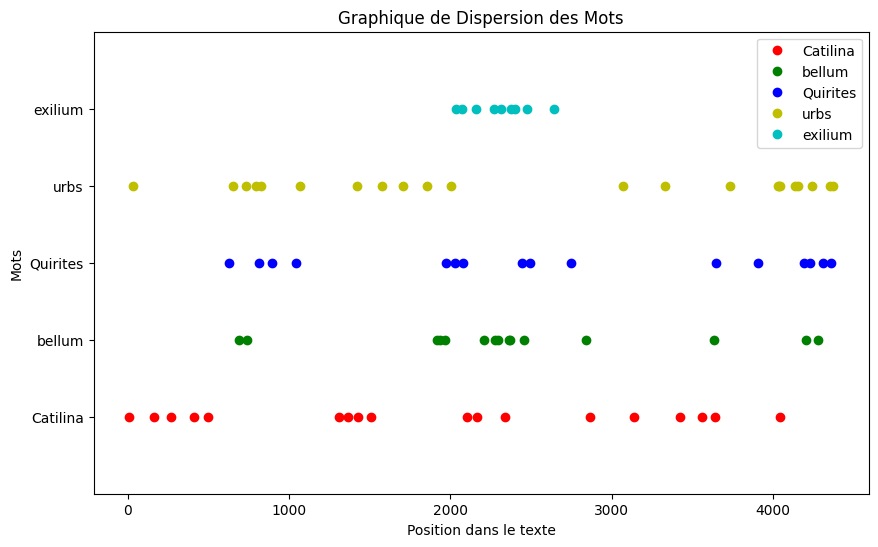

In [91]:
plot_word_dispersion(text=lemmas_catilinaires, words=['Catilina', 'bellum', 'Quirites', 'urbs', 'exilium'])

Let's try now a basic module to generate word clouds, with `wordcloud`.

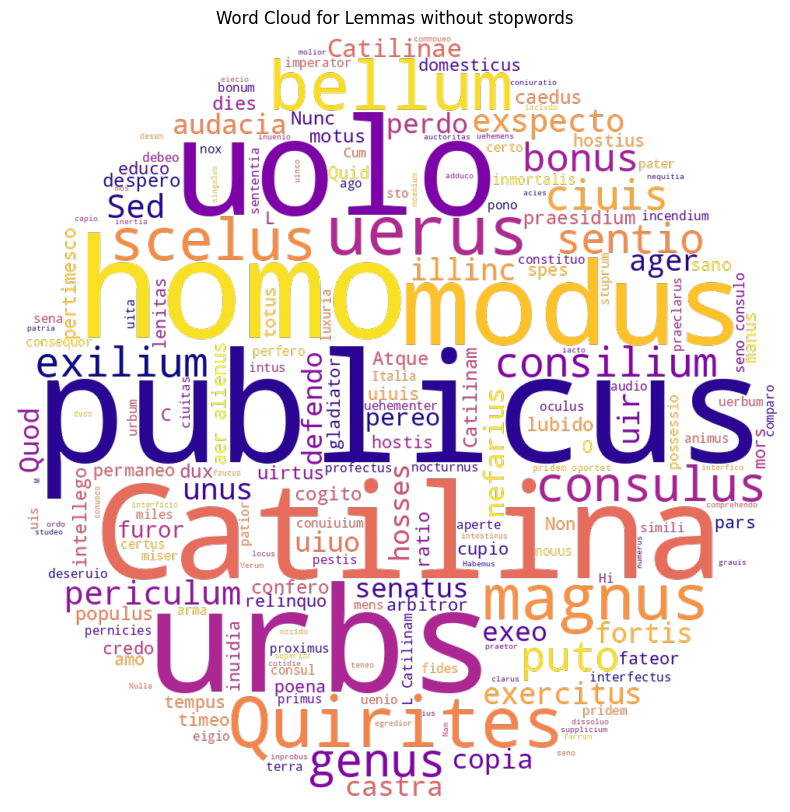

In [117]:
create_word_cloud(filtered_lemmas, 'Word Cloud for Lemmas without stopwords')